In [ ]:
#!pip install --trusted-host=pypi.org --trusted-host=files.pythonhosted.org --user tensorflow-macos

In [ ]:
#!python --version

In [1]:
import os
import sys
import random

#TODO Make universal imports for all py files?

os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#sys.modules['keras'] = keras

import numpy as np

from dice import dice_coef, dice_loss
from generator import DataGen
from visualize import display_slice_from_batch

seed = 2019
random.seed = seed
#TODO make config[seed] and fix below
#np.random.seed = seed
tf.seed = seed

In [2]:
tf.debugging.set_log_device_placement(True)


In [4]:
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


In [5]:
patch_size = 32 # The size of the cube volumes in quickstart-gendata. You specified this in the previous notebook.
percent_covered = 1e-10
train_path = "quickstart-gendata/train"
model_path = "jan30_largeframe_32_nonzero_standardized_local.keras" # Name your model
epochs = 70
patience = 4
batch_size = 32

train_ids = next(os.walk(train_path))[1] # Returns all directories under train_path

val_data_size = 2 # Needs to be greater than batch_size

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [6]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=patch_size, patch_size=patch_size,
              percent_covered = percent_covered)
x, y = gen.__getitem__(0)
#0 - 37
print(x.shape, y.shape)

(32, 32, 32, 32, 1) (32, 32, 32, 32, 1)


(32, 32, 1)
4.469361177393602
1.0


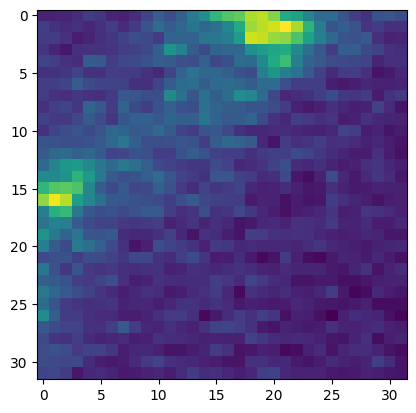

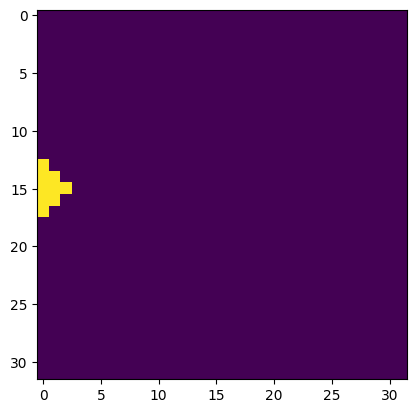

In [7]:
# View patches from the batch generated above.
# Change z to look at different slices.

n=0
z=30

display_slice_from_batch(x, n, z)
print(x[n, :, :, z].shape)
print(np.amax(x[n, :, :, z]))


display_slice_from_batch(y, n, z)
print(np.amax(y[n, :, :, :]))


In [8]:
# Neural network blocks
def down_block(x, filters, kernel_size=(3, 3, 3), padding="same", strides=(1, 1, 1)):
    c = keras.layers.Conv3D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv3D(filters*2, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool3D((2, 2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3, 3), padding="same", strides=(1, 1, 1)):
    us = keras.layers.Conv3DTranspose(filters*4, (2, 2, 2), (2, 2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv3D(filters*2, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv3D(filters*2, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3, 3), padding="same", strides=(1, 1, 1)):
    c = keras.layers.Conv3D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv3D(filters*2, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [9]:
# Model Architecture
def UNet():
    #f = [16, 32, 64, 128, 256]
    f = [32, 64, 128, 256]
    inputs = keras.layers.Input((patch_size, patch_size, patch_size, 1))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #32 -> 16
    c2, p2 = down_block(p1, f[1]) #16 -> 8
    c3, p3 = down_block(p2, f[2]) #8 -> 4
    #c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p3, f[3])
    
    u1 = up_block(bn, c3, f[2]) #4 -> 8
    u2 = up_block(u1, c2, f[1]) #8 -> 16
    u3 = up_block(u2, c1, f[0]) #16 -> 32
    #u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv3D(1, (1, 1, 1), padding="same", activation="sigmoid")(u3)
    model = keras.models.Model(inputs, outputs)
    return model

In [10]:
# Create model
model = UNet()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=dice_loss(smooth=1.), metrics=[dice_coef, 'accuracy'])#, sample_weight_mode="temporal")
model.summary()

#TODO Does valid_gen use percent_covered = 0 or nonzero?
train_gen = DataGen(train_ids, train_path, image_size=patch_size, patch_size=patch_size, batch_size=batch_size, percent_covered=percent_covered)
valid_gen = DataGen(valid_ids, train_path, image_size=patch_size, patch_size=patch_size, batch_size=batch_size, percent_covered=percent_covered)

Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localh

2024-06-07 23:49:15.850918: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-06-07 23:49:15.850970: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-06-07 23:49:15.850983: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-06-07 23:49:15.851021: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-07 23:49:15.851043: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-06-07 23:49:15.864738: I tensorflow/core/common_runtime/placer.cc:125] x: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:49:15.864754: I tensorflow/core/com

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:l

2024-06-07 23:49:16.070743: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:49:16.070755: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:49:16.071450: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:49:16.071455: I tensorflow/core/common_runtime/placer.cc:125] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:49:16.071458: I tensorflow/core/common_runtime/placer.cc:125] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:49:16.084673: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:49:16.084683: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in

2024-06-07 23:49:16.271855: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:49:16.271863: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:49:16.272379: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:49:16.272383: I tensorflow/core/common_runtime/placer.cc:125] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:49:16.272386: I tensorflow/core/common_runtime/placer.cc:125] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:49:16.275340: I tensorflow/core/common_runtime/placer.cc:125] input: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:49:16.275347: I tensorflow/core/common_runtime/placer.cc:125] _EagerConst: (_EagerConst): /job:localhost/replica:0/tas

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32,    │          0 │ -                 │
│ (InputLayer)        │ 32, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 32, 32,    │        896 │ input_layer[0][0] │
│                     │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 32, 32,    │     55,360 │ conv3d[0][0]      │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 16, 16,    │          0 │ conv3d_1[0][0]    │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 16, 16,    │    110,656 │ max_pooling3d[0]… │
│                     │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 16, 16,    │    221,312 │ conv3d_2[0][0]    │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 8, 8, 8,   │          0 │ conv3d_3[0][0]    │
│ (MaxPooling3D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 8, 8, 8,   │    442,496 │ max_pooling3d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 8, 8, 8,   │    884,992 │ conv3d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 4, 4, 4,   │          0 │ conv3d_5[0][0]    │
│ (MaxPooling3D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 4, 4, 4,   │  1,769,728 │ max_pooling3d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_7 (Conv3D)   │ (None, 4, 4, 4,   │  3,539,456 │ conv3d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_transpose    │ (None, 8, 8, 8,   │  2,097,664 │ conv3d_7[0][0]    │
│ (Conv3DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8, 8,   │          0 │ conv3d_transpose… │
│ (Concatenate)       │ 768)              │            │ conv3d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_8 (Conv3D)   │ (None, 8, 8, 8,   │  5,308,672 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_9 (Conv3D)   │ (None, 8, 8, 8,   │  1,769,728 │ conv3d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_transpose_1  │ (None, 16, 16,    │    524,544 │ conv3d_9[0][0]  

 Total params: 19,068,993 (72.74 MB)

 Trainable params: 19,068,993 (72.74 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the model
train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

callbacks = [EarlyStopping(monitor='val_loss', patience=patience, verbose=1),
             ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=True, verbose=1),
             ReduceLROnPlateau(factor=0.5, patience=2, verbose=1)]

history = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs, callbacks=callbacks)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DummySeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 1/70
Executing op AnonymousIteratorV3 in device /job:localhost/replica:0/task:0/dev

2024-06-07 23:49:25.904007: I tensorflow/core/common_runtime/placer.cc:125] components_0: (_DeviceArg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:49:25.904020: I tensorflow/core/common_runtime/placer.cc:125] TensorDataset: (TensorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:49:25.904022: I tensorflow/core/common_runtime/placer.cc:125] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:49:25.911978: I tensorflow/core/common_runtime/placer.cc:125] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:49:25.911989: I tensorflow/core/common_runtime/placer.cc:125] FlatMapDataset: (FlatMapDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:49:25.911991: I tensorflow/core/common_runtime/placer.cc:125] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:49:25.916247: I tensorflow/core/common_runtime/placer.cc:125] handle_RetVal: (_Retval): /j

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

2024-06-07 23:49:26.108439: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:49:26.108448: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:49:26.131299: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:49:26.131313: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:49:26.139908: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:49:26.139920: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:49:26.144413: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /j

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0


2024-06-07 23:49:26.311823: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:49:26.311830: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:49:26.315541: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:49:26.315547: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:49:26.319432: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:49:26.319440: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:49:26.323223: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /j

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /

2024-06-07 23:49:26.558418: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:49:26.558429: I tensorflow/core/common_runtime/placer.cc:125] VarIsInitializedOp: (VarIsInitializedOp): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:49:26.558432: I tensorflow/core/common_runtime/placer.cc:125] is__initialized_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:49:26.560445: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:49:26.560451: I tensorflow/core/common_runtime/placer.cc:125] VarIsInitializedOp: (VarIsInitializedOp): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:49:26.560453: I tensorflow/core/common_runtime/placer.cc:125] is__initialized_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:49:26.561982: I tensorflow/core/common_runtime/placer.cc:125] resource

:localhost/replica:0/task:0/device:GPU:0
AssignVariableOp_49: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
AssignVariableOp_50: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
AssignVariableOp_51: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
AssignVariableOp_52: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
AssignVariableOp_53: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
AssignVariableOp_54: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
AssignVariableOp_55: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
AssignVariableOp_56: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
AssignVariableOp_57: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
AssignVariableOp_58: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
AssignVariableOp_59: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
AssignVariabl

2024-06-07 23:49:27.269774: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:49:27.269781: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:49:27.269783: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:49:27.269785: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:49:27.269788: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:49:27.269790: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:49:27.271439: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
1/5 ━━━━━━━━━━━━━━━━━━━━ 2:20 35s/step - accuracy: 0.5623 - dice_coef: 0.0202 - loss: -0.0202Executing op __inference_one_step_on_iterator_6373 in device /job:

2024-06-07 23:50:00.944155: I tensorflow/core/common_runtime/placer.cc:125] start: (_DeviceArg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:50:00.944168: I tensorflow/core/common_runtime/placer.cc:125] limit: (_DeviceArg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:50:00.944175: I tensorflow/core/common_runtime/placer.cc:125] delta: (_DeviceArg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:50:00.944178: I tensorflow/core/common_runtime/placer.cc:125] Range: (Range): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:50:00.944180: I tensorflow/core/common_runtime/placer.cc:125] output_RetVal: (_DeviceRetval): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:50:00.945067: I tensorflow/core/common_runtime/placer.cc:125] input: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:50:00.945072: I tensorflow/core/common_runtime/placer.cc:125] reduction__indices: (_DeviceArg): /job:localhost/replica:0/task:0/device

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
2/5 ━━━━━━━━━━━━━━━━━━━━ 21s 7s/step - accuracy: 0.5622 - dice_coef: 0.0209 - loss: -0.0204  Executing op __inference_one_step_on_iterator_6373 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localh

2024-06-07 23:50:53.186439: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:50:53.186448: I tensorflow/core/common_runtime/placer.cc:125] ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:50:53.186451: I tensorflow/core/common_runtime/placer.cc:125] value_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:50:53.187312: I tensorflow/core/common_runtime/placer.cc:125] x: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:50:53.187319: I tensorflow/core/common_runtime/placer.cc:125] y: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:50:53.187323: I tensorflow/core/common_runtime/placer.cc:125] DivNoNan: (DivNoNan): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:50:53.187325: I tensorflow/core/common_runtime/placer.cc:125] z_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 1: val_loss improved from inf t

2024-06-07 23:50:53.763650: I tensorflow/core/common_runtime/placer.cc:125] x: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:50:53.763658: I tensorflow/core/common_runtime/placer.cc:125] y: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:50:53.763661: I tensorflow/core/common_runtime/placer.cc:125] Less: (Less): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:50:53.763663: I tensorflow/core/common_runtime/placer.cc:125] z_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:50:53.828924: I tensorflow/core/common_runtime/placer.cc:125] input: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:50:53.828933: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:50:53.828935: I tensorflow/core/common_runtime/placer.cc:125] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:50:53.832254: I ten

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

2024-06-07 23:50:53.966466: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:50:53.966475: I tensorflow/core/common_runtime/placer.cc:125] ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:50:53.966478: I tensorflow/core/common_runtime/placer.cc:125] value_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:50:53.967702: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:50:53.967712: I tensorflow/core/common_runtime/placer.cc:125] ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:50:53.967714: I tensorflow/core/common_runtime/placer.cc:125] value_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:50:53.969495: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/t

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

2024-06-07 23:50:54.211774: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:50:54.211785: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:50:54.213764: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2024-06-07 23:50:54.213773: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0


Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
1/5 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step - accuracy: 0.4826 - dice_coef: 0.0141 - loss: -0.0141Executing op __inference_one_step_on_iterator_6373 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /

2024-06-07 23:51:01.023992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-07 23:51:01.024028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/functional_1_1/conv3d_4_1/convolution/Conv3DBackpropFilterV2/_420]]
2024-06-07 23:51:01.024036: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10911478381103111906
2024-06-07 23:51:01.024038: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7701395829810561862
2024-06-07 23:51:01.024041: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18324437220022192366
2024-06-07 23:51:01.024043: I tensorflow/core/framework/local_rendezvous.

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 2: val_loss improved from -0.03911 to -0.03979, saving model to jan30_largeframe_32_nonzero_standardized_local.

2024-06-07 23:51:01.797750: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:51:01.797761: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:51:01.797764: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:51:01.797767: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:51:01.797769: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:51:01.797772: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:51:01.800157: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
1/5 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step - accuracy: 0.5047 - dice_coef: 0.0140 - loss: -0.0140Executing op __inference_one_step_on_iterator_6373 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhos

2024-06-07 23:51:32.145813: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:51:32.145823: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:51:32.145825: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:51:32.145827: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:51:32.145829: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:51:32.145830: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:51:32.148350: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 3: val_loss improved from -0.03979 to -0.04293, saving model to jan30_largeframe_32_nonzero_standardized_local.

2024-06-07 23:52:03.345364: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:52:03.345374: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:52:03.345376: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:52:03.345378: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:52:03.345380: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:52:03.345382: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:52:03.347993: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 4: val_loss improved from -0.04293 to -0.04562, saving model to jan30_largeframe_32_nonzero_standardized_local.

2024-06-07 23:52:34.496293: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:52:34.496303: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:52:34.496305: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:52:34.496307: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:52:34.496309: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:52:34.496310: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:52:34.498984: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 5: val_loss improved from -0.04562 to -0.04825, saving model to jan30_largeframe_32_nonzero_standardized_local.

2024-06-07 23:53:00.073234: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:53:00.073243: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:53:00.073245: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:53:00.073247: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:53:00.073249: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:53:00.073251: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:53:00.075689: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 6: val_loss improved from -0.04825 to -0.05191, saving model to jan30_largeframe_32_nonzero_standardized_local.

2024-06-07 23:53:23.537070: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:53:23.537079: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:53:23.537082: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:53:23.537084: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:53:23.537085: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:53:23.537087: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:53:23.539681: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 7: val_loss improved from -0.05191 to -0.05790, saving model to jan30_largeframe_32_nonzero_standardized_local.

2024-06-07 23:53:40.565315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-07 23:53:40.565328: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7731545873806966978
2024-06-07 23:53:40.565331: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14380643807095202300
2024-06-07 23:53:40.565334: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1349940752164315674
2024-06-07 23:53:40.565336: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7701395829810561862
2024-06-07 23:53:40.565339: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3655474475660150218
2024-06-07 23:53:40.565341: I tensorflow/core/framework/local_rendezvo

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 8: val_loss improved from -0.05790 to -0.06384, saving model to jan30_largeframe_32_nonzero_standardized_local.

2024-06-07 23:53:41.368881: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:53:41.368891: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:53:41.368894: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:53:41.368896: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:53:41.368899: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:53:41.368901: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:53:41.372116: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
1/5 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.8037 - dice_coef: 0.0204 - loss: -0.0204Executing op __inference_one_step_on_iterator_6373 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhos

2024-06-07 23:54:02.271767: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:54:02.271777: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:54:02.271780: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:54:02.271783: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:54:02.271785: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:54:02.271787: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:54:02.274423: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 9: val_loss improved from -0.06384 to -0.07730, saving model to jan30_largeframe_32_nonzero_standardized_local.

2024-06-07 23:54:24.179586: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:54:24.179596: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:54:24.179598: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:54:24.179600: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:54:24.179602: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:54:24.179603: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:54:24.182599: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 10: val_loss improved from -0.07730 to -0.09091, saving model to jan30_largeframe_32_nonzero_standardized_local

2024-06-07 23:54:46.655087: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:54:46.655098: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:54:46.655101: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:54:46.655103: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:54:46.655106: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:54:46.655108: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:54:46.657892: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 11: val_loss improved from -0.09091 to -0.11436, saving model to jan30_largeframe_32_nonzero_standardized_local

2024-06-07 23:55:08.108445: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:55:08.108454: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:55:08.108457: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:55:08.108459: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:55:08.108461: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:55:08.108463: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:55:08.111099: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 12: val_loss improved from -0.11436 to -0.14392, saving model to jan30_largeframe_32_nonzero_standardized_local

2024-06-07 23:55:29.578821: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:55:29.578830: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:55:29.578833: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:55:29.578835: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:55:29.578836: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:55:29.578838: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:55:29.581997: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 13: val_loss improved from -0.14392 to -0.18273, saving model to jan30_largeframe_32_nonzero_standardized_local

2024-06-07 23:55:50.922855: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:55:50.922865: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:55:50.922867: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:55:50.922869: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:55:50.922871: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:55:50.922873: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:55:50.925847: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 14: val_loss improved from -0.18273 to -0.22938, saving model to jan30_largeframe_32_nonzero_standardized_local

2024-06-07 23:56:06.455850: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:56:06.455861: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:56:06.455864: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:56:06.455866: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:56:06.455869: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:56:06.455871: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:56:06.458514: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 15: val_loss improved from -0.22938 to -0.26625, saving model to jan30_largeframe_32_nonzero_standardized_local

2024-06-07 23:56:19.960011: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:56:19.960021: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:56:19.960024: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:56:19.960026: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:56:19.960029: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:56:19.960031: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:56:19.963291: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 16: val_loss did not improve from -0.26625
Executing op ReadVariableOp in device /job:localhost/replica:0/task:

2024-06-07 23:56:26.552504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-07 23:56:26.552517: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7731545873806966978
2024-06-07 23:56:26.552520: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14380643807095202300
2024-06-07 23:56:26.552522: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7701395829810561862
2024-06-07 23:56:26.552525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/functional_1_1/conv3d_11_1/convolution/Conv3DBackpropFilterV2/_438]]
2024-06-07 23:56:26.552528: I tensorflow/core/framework/local_rendezvous.

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 17: val_loss did not improve from -0.26625
Executing op ReadVariableOp in device /job:localhost/replica:0/task:

2024-06-07 23:56:26.908541: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:56:26.908551: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:56:26.908554: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:56:26.908556: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:56:26.908558: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:56:26.908561: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:56:26.911589: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
1/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9518 - dice_coef: 0.0422 - loss: -0.0422Executing op __inference_one_step_on_iterator_6373 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost

2024-06-07 23:56:37.897709: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:56:37.897719: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:56:37.897722: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:56:37.897723: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:56:37.897725: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:56:37.897727: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:56:37.900271: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 18: val_loss did not improve from -0.26625
Executing op ReadVariableOp in device /job:localhost/replica:0/task:

2024-06-07 23:56:49.208751: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:56:49.208762: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:56:49.208765: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:56:49.208768: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:56:49.208770: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:56:49.208772: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:56:49.211539: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 19: val_loss improved from -0.26625 to -0.26656, saving model to jan30_largeframe_32_nonzero_standardized_local

2024-06-07 23:57:00.918258: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:00.918267: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:00.918270: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:00.918272: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:00.918274: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:00.918276: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:00.920850: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 20: val_loss improved from -0.26656 to -0.30541, saving model to jan30_largeframe_32_nonzero_standardized_local

2024-06-07 23:57:12.578633: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:12.578642: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:12.578645: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:12.578648: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:12.578650: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:12.578652: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:12.581161: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 21: val_loss improved from -0.30541 to -0.31484, saving model to jan30_largeframe_32_nonzero_standardized_local

2024-06-07 23:57:24.506841: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:24.506850: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:24.506856: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:24.506858: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:24.506860: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:24.506861: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:24.509460: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 22: val_loss did not improve from -0.31484
Executing op ReadVariableOp in device /job:localhost/replica:0/task:

2024-06-07 23:57:35.772750: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:35.772759: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:35.772761: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:35.772763: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:35.772765: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:35.772767: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:35.775274: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 23: val_loss improved from -0.31484 to -0.31915, saving model to jan30_largeframe_32_nonzero_standardized_local

2024-06-07 23:57:47.368977: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:47.368986: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:47.368989: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:47.368990: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:47.368992: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:47.368994: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:47.372334: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 24: val_loss improved from -0.31915 to -0.32979, saving model to jan30_largeframe_32_nonzero_standardized_local

2024-06-07 23:57:58.936125: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:58.936134: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:58.936137: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:58.936139: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:58.936141: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:58.936143: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:57:58.938670: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 25: val_loss did not improve from -0.32979
Executing op ReadVariableOp in device /job:localhost/replica:0/task:

2024-06-07 23:58:10.139701: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:58:10.139711: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:58:10.139714: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:58:10.139716: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:58:10.139717: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:58:10.139719: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:58:10.142472: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 26: val_loss improved from -0.32979 to -0.34296, saving model to jan30_largeframe_32_nonzero_standardized_local

2024-06-07 23:58:21.746949: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:58:21.746959: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:58:21.746962: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:58:21.746963: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:58:21.746965: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:58:21.746967: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:58:21.749399: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 27: val_loss improved from -0.34296 to -0.34503, saving model to jan30_largeframe_32_nonzero_standardized_local

2024-06-07 23:58:33.354725: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:58:33.354735: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:58:33.354737: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:58:33.354739: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:58:33.354741: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:58:33.354743: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:58:33.357400: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 28: val_loss did not improve from -0.34503
Executing op ReadVariableOp in device /job:localhost/replica:0/task:

2024-06-07 23:58:44.557746: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:58:44.557755: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:58:44.557758: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:58:44.557759: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:58:44.557761: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:58:44.557763: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:58:44.560319: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 29: val_loss did not improve from -0.34503
Executing op ReadVariableOp in device /job:localhost/replica:0/task:

2024-06-07 23:58:55.931716: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:58:55.931727: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:58:55.931730: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:58:55.931733: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:58:55.931735: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:58:55.931737: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:58:55.934588: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 30: val_loss improved from -0.34503 to -0.35601, saving model to jan30_largeframe_32_nonzero_standardized_local

2024-06-07 23:59:07.553140: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:59:07.553149: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:59:07.553151: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:59:07.553153: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:59:07.553155: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:59:07.553157: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:59:07.555643: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 31: val_loss improved from -0.35601 to -0.36433, saving model to jan30_largeframe_32_nonzero_standardized_local

2024-06-07 23:59:19.186333: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:59:19.186343: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:59:19.186345: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:59:19.186351: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:59:19.186354: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:59:19.186355: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:59:19.189618: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 32: val_loss did not improve from -0.36433
Executing op ReadVariableOp in device /job:localhost/replica:0/task:

2024-06-07 23:59:30.392932: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:59:30.392941: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:59:30.392943: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:59:30.392946: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:59:30.392947: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:59:30.392949: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:59:30.395427: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 33: val_loss did not improve from -0.36433
Executing op ReadVariableOp in device /job:localhost/replica:0/task:

2024-06-07 23:59:37.266403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-07 23:59:37.266485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/functional_1_1/conv3d_11_1/convolution/Conv3DBackpropFilterV2/_438]]
2024-06-07 23:59:37.266490: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7731545873806966978
2024-06-07 23:59:37.266493: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7701395829810561862
2024-06-07 23:59:37.266497: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3655474475660150218
2024-06-07 23:59:37.266500: I tensorflow/core/framework/local_rendezvous.c

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 34: val_loss did not improve from -0.36433
Executing op ReadVariableOp in device /job:localhost/replica:0/task:

2024-06-07 23:59:37.625695: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:59:37.625704: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:59:37.625707: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:59:37.625708: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:59:37.625710: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:59:37.625712: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:59:37.627908: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
1/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9914 - dice_coef: 0.1309 - loss: -0.1309Executing op __inference_one_step_on_iterator_6373 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost

2024-06-07 23:59:48.575800: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:59:48.575811: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:59:48.575813: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:59:48.575815: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:59:48.575817: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:59:48.575819: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-07 23:59:48.578536: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 35: val_loss improved from -0.36433 to -0.36521, saving model to jan30_largeframe_32_nonzero_standardized_local

2024-06-08 00:00:00.211516: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:00.211526: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:00.211528: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:00.211530: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:00.211532: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:00.211534: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:00.214092: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 36: val_loss improved from -0.36521 to -0.36665, saving model to jan30_largeframe_32_nonzero_standardized_local

2024-06-08 00:00:11.875015: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:11.875024: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:11.875030: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:11.875032: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:11.875034: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:11.875035: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:11.877666: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 37: val_loss improved from -0.36665 to -0.36952, saving model to jan30_largeframe_32_nonzero_standardized_local

2024-06-08 00:00:23.532664: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:23.532673: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:23.532676: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:23.532678: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:23.532679: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:23.532681: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:23.535380: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 38: val_loss improved from -0.36952 to -0.37459, saving model to jan30_largeframe_32_nonzero_standardized_local

2024-06-08 00:00:35.257788: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:35.257798: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:35.257801: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:35.257803: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:35.257804: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:35.257806: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:35.260351: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 39: val_loss improved from -0.37459 to -0.37462, saving model to jan30_largeframe_32_nonzero_standardized_local

2024-06-08 00:00:46.858043: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:46.858055: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:46.858057: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:46.858060: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:46.858062: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:46.858065: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:46.860624: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 40: val_loss improved from -0.37462 to -0.37545, saving model to jan30_largeframe_32_nonzero_standardized_local

2024-06-08 00:00:58.489625: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:58.489635: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:58.489637: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:58.489639: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:58.489641: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:58.489643: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:00:58.492265: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 41: val_loss improved from -0.37545 to -0.37665, saving model to jan30_largeframe_32_nonzero_standardized_local

2024-06-08 00:01:10.092014: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:01:10.092025: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:01:10.092027: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:01:10.092029: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:01:10.092031: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:01:10.092033: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:01:10.095129: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 42: val_loss improved from -0.37665 to -0.37724, saving model to jan30_largeframe_32_nonzero_standardized_local

2024-06-08 00:01:21.678680: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:01:21.678690: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:01:21.678692: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:01:21.678694: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:01:21.678696: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:01:21.678698: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:01:21.681696: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 43: val_loss did not improve from -0.37724
Executing op ReadVariableOp in device /job:localhost/replica:0/task:

2024-06-08 00:01:32.899771: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:01:32.899781: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:01:32.899783: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:01:32.899785: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:01:32.899787: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:01:32.899789: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:01:32.902333: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 44: val_loss improved from -0.37724 to -0.37827, saving model to jan30_largeframe_32_nonzero_standardized_local

2024-06-08 00:01:44.555667: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:01:44.555677: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:01:44.555679: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:01:44.555681: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:01:44.555683: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:01:44.555685: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:01:44.558228: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 45: val_loss improved from -0.37827 to -0.37867, saving model to jan30_largeframe_32_nonzero_standardized_local

2024-06-08 00:01:56.144524: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:01:56.144535: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:01:56.144537: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:01:56.144539: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:01:56.144541: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:01:56.144543: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:01:56.147061: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 46: val_loss did not improve from -0.37867
Executing op ReadVariableOp in device /job:localhost/replica:0/task:

2024-06-08 00:02:07.319492: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:02:07.319501: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:02:07.319504: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:02:07.319506: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:02:07.319508: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:02:07.319509: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:02:07.322020: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 47: val_loss did not improve from -0.37867
Executing op ReadVariableOp in device /job:localhost/replica:0/task:

2024-06-08 00:02:18.519925: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:02:18.519935: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:02:18.519937: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:02:18.519939: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:02:18.519941: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:02:18.519943: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:02:18.522520: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 48: val_loss did not improve from -0.37867
Executing op ReadVariableOp in device /job:localhost/replica:0/task:

2024-06-08 00:02:29.728350: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:02:29.728359: I tensorflow/core/common_runtime/placer.cc:125] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:02:29.728361: I tensorflow/core/common_runtime/placer.cc:125] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:02:29.728364: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:02:29.728366: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:02:29.728368: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:02:29.730886: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DivNoNan in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Less in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 49: val_loss did not improve from -0.37867
Executing op ReadVariableOp in device /job:localhost/replica:0/task:

dict_keys(['accuracy', 'dice_coef', 'loss', 'val_accuracy', 'val_dice_coef', 'val_loss', 'learning_rate'])


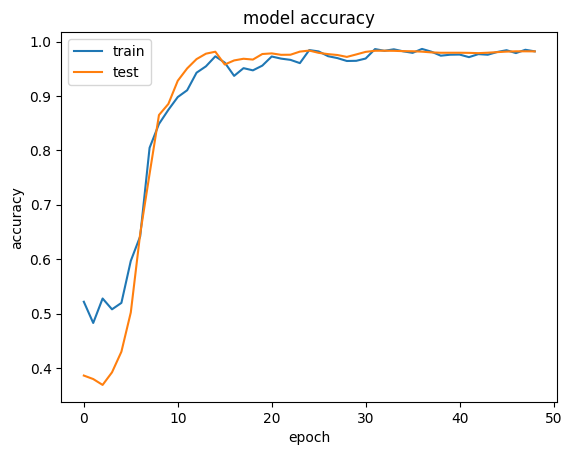

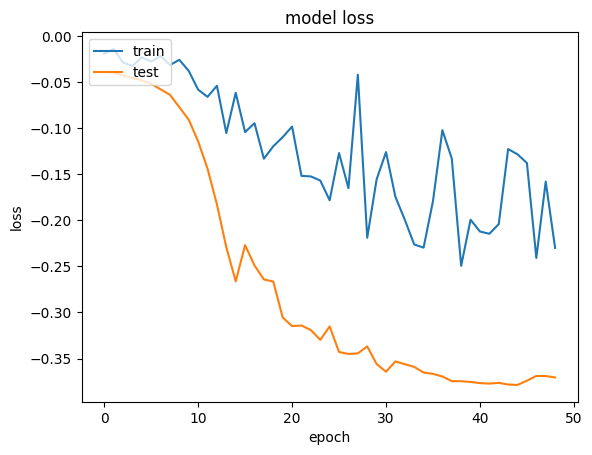

In [13]:
# View training statistics
import matplotlib.pyplot as plt
%matplotlib inline

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing o

2024-06-08 00:22:03.831660: I tensorflow/core/common_runtime/placer.cc:125] start: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:22:03.831693: I tensorflow/core/common_runtime/placer.cc:125] stop: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:22:03.831718: I tensorflow/core/common_runtime/placer.cc:125] step: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:22:03.831733: I tensorflow/core/common_runtime/placer.cc:125] RangeDataset: (RangeDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:22:03.831738: I tensorflow/core/common_runtime/placer.cc:125] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:22:03.851190: I tensorflow/core/common_runtime/placer.cc:125] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-06-08 00:22:03.851206: I tensorflow/core/common_runtime/placer.cc:125] MapDataset: (MapDataset): /job:localhost/replica:0/task:0/device:CPU:0
2024

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
(2, 32, 32, 32, 1)


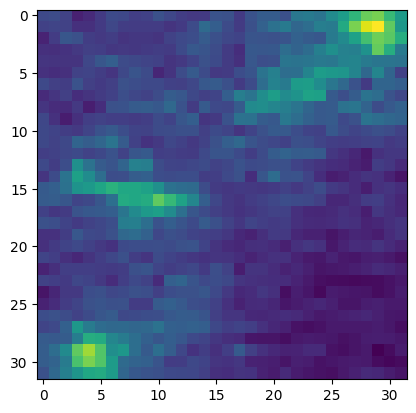

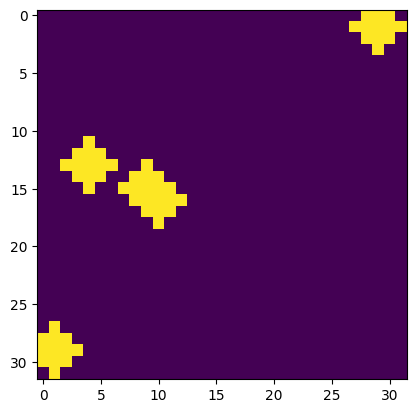

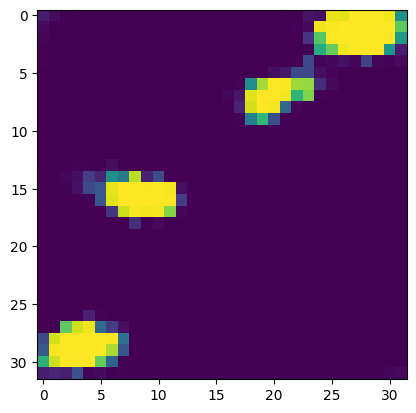

In [22]:
# Quickly view predictions on patches with the trained model.
# Predictions for larger data will need to be done in the next notebook.

test_gen = DataGen(valid_ids, train_path, image_size=patch_size, patch_size=patch_size, batch_size=batch_size, percent_covered=0)
x, y = test_gen.__getitem__(0)
result = model.predict(x)

n=1
z=2

print(x.shape)
display_slice_from_batch(x,n,z)
display_slice_from_batch(y,n,z)
display_slice_from_batch(result,n,z)

In [15]:
# Run this if you want to save the training history
import pickle
with open('trainHistoryDict_overnight', 'wb') as handle: # saving the history of the model
    pickle.dump(history.history, handle)